In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
modSourceDir= '/results2/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [6]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [7]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [8]:
groups=pd.read_csv('/data/eolson/results/MEOPAR/clusterGroups/cluster_consolidated.csv')

In [9]:
groups.keys()

Index(['I', 'j', 'Cluster_ID'], dtype='object')

In [10]:
cset0=set([(ii,jj) for ii,jj in groups.loc[:,['I','j']].values])

In [11]:
pdlist=list()
cset1=set()
for i,row in groups.iterrows():
    for ii in range(-5,5):
        for jj in range(-5,5):
            if not (row['I']+ii,row['j']+jj) in cset0|cset1:
                pdlist.append((row['I']+ii,row['j']+jj,row['Cluster_ID']))
                cset1.add((row['I']+ii,row['j']+jj))

In [12]:
newpd=pd.DataFrame(columns=['I', 'j', 'Cluster_ID'],data=pdlist)

In [13]:
data.keys()

Index(['FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat', 'Lon',
       'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Cyanobacteria',
       'Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'TchlA (ug/L)', 'Pressure [decibar]',
       'Transmissivity [*/metre]', 'PAR [uE/m^2/sec]',
       'PAR:Reference [uE/m^2/sec]', 'Oxygen:Dissolved:SBE [mL/L]',
       'Oxygen:Dissolved:SBE [umol/kg]', 'Chlorophyll:Extracted [mg/m^3]',
       'Phaeo-Pigment:Extracted [mg/m^3]', 'Nitrate_plus_Nitrite [umol/L]',
       'Silicate [umol/L]', 'Phosphate [umol/L]', 'Bottle_Number',
       'Oxygen:Dissolved [mL/L]', 'Oxygen:Dissolved [umol/kg]',
       'Depth [metres]', 'Fluorescence [mg/m^3

(640, 700)

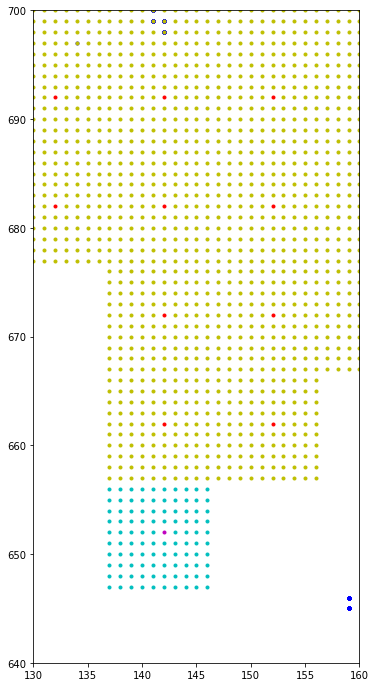

In [14]:
fig,ax=plt.subplots(1,1,figsize=(6,12))
ax.plot(data['i'],data['j'],'b.')
ax.plot(groups.loc[groups['Cluster_ID']=='NORTH',['I']].values,groups.loc[groups['Cluster_ID']=='NORTH',['j']],'r.')
ax.plot(groups.loc[groups['Cluster_ID']=='SOUTH',['I']].values,groups.loc[groups['Cluster_ID']=='SOUTH',['j']],'m.')
ax.plot(newpd.loc[newpd['Cluster_ID']=='NORTH',['I']].values,newpd.loc[newpd['Cluster_ID']=='NORTH',['j']],'y.')
ax.plot(newpd.loc[newpd['Cluster_ID']=='SOUTH',['I']].values,newpd.loc[newpd['Cluster_ID']=='SOUTH',['j']],'c.')
ax.set_aspect(1)
ax.set_xlim(130,160)
ax.set_ylim(640,700)

In [15]:
data2=pd.merge(data,pd.concat((newpd,groups)),how='inner',left_on=['i','j'],right_on=['I','j'])

In [16]:
len(data),len(data2),len(groups)

(5607, 1444, 146)

In [17]:
data2.loc[:,['i','j','Cluster_ID','mod_diatoms','Diatoms-1']]

,i,j,Cluster_ID,mod_diatoms,Diatoms-1
0,245,487,SOUTH,1.346822,1.677
1,245,487,SOUTH,0.133013,0.710
2,245,487,SOUTH,0.380877,0.658
3,245,487,SOUTH,0.158944,0.218
4,245,487,SOUTH,0.159075,NaN
...,...,...,...,...,...
1439,146,735,NORTH,0.292580,NaN
1440,146,735,NORTH,0.023296,NaN
1441,222,606,SOUTH,0.085162,0.228
1442,222,606,SOUTH,0.054806,NaN


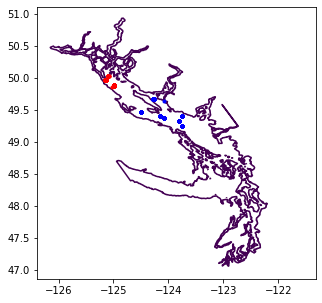

In [18]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
r1=data2.Cluster_ID=='NORTH'
r2=data2.Cluster_ID=='SOUTH'
ax.plot(data2.loc[r1,['Lon']].values,data2.loc[r1,['Lat']].values,'r.')
ax.plot(data2.loc[r2,['Lon']].values,data2.loc[r2,['Lat']].values,'b.')

In [19]:
data2.loc[r1,['Diatoms-1','Diatoms-2','mod_diatoms']]

,Diatoms-1,Diatoms-2,mod_diatoms
479,0.010,0.15,2.589933
480,NaN,NaN,1.019906
481,NaN,NaN,0.562324
482,NaN,NaN,0.393980
483,NaN,NaN,0.290062
...,...,...,...
1436,NaN,NaN,0.006073
1437,NaN,NaN,0.003910
1438,0.003,9.81,0.447318
1439,NaN,NaN,0.292580


In [20]:
def logt(x):
    return np.log10(x+.001)

In [21]:
data2.keys()

Index(['FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat', 'Lon',
       'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Cyanobacteria',
       'Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'TchlA (ug/L)', 'Pressure [decibar]',
       'Transmissivity [*/metre]', 'PAR [uE/m^2/sec]',
       'PAR:Reference [uE/m^2/sec]', 'Oxygen:Dissolved:SBE [mL/L]',
       'Oxygen:Dissolved:SBE [umol/kg]', 'Chlorophyll:Extracted [mg/m^3]',
       'Phaeo-Pigment:Extracted [mg/m^3]', 'Nitrate_plus_Nitrite [umol/L]',
       'Silicate [umol/L]', 'Phosphate [umol/L]', 'Bottle_Number',
       'Oxygen:Dissolved [mL/L]', 'Oxygen:Dissolved [umol/kg]',
       'Depth [metres]', 'Fluorescence [mg/m^3

## Time Series

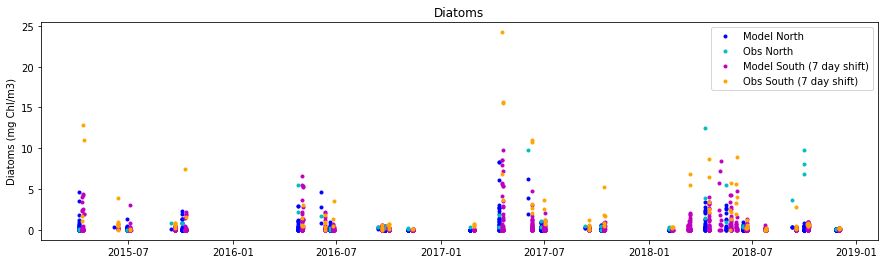

In [22]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(data2.loc[r1,['dtUTC']].values,1.8*(data2.loc[r1,['mod_diatoms']].values),'b.',label='Model North')
ax.plot(data2.loc[r1,['dtUTC']].values,
        data2.loc[r1,['Diatoms-1']].values+data2.loc[r1,['Diatoms-2']].values,
        'c.',label='Obs North')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        1.8*(data2.loc[r2,['mod_diatoms']].values),'m.',label='Model South (7 day shift)')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        data2.loc[r2,['Diatoms-1']].values+data2.loc[r2,['Diatoms-2']].values,
        '.',color='orange',label='Obs South (7 day shift)')
ax.set_ylabel('Diatoms (mg Chl/m3)')
ax.set_title('Diatoms');
ax.legend()

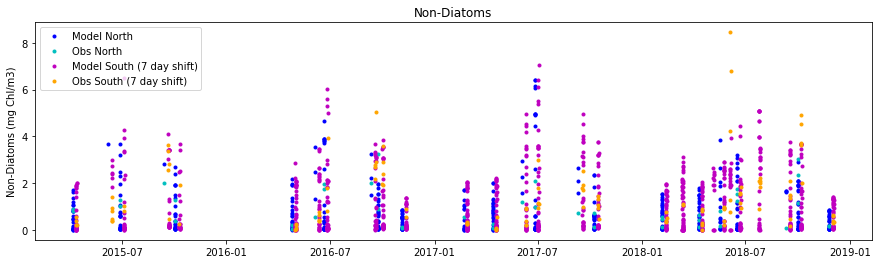

In [23]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(data2.loc[r1,['dtUTC']].values,
        1.8*(data2.loc[r1,['mod_flagellates']].values+data2.loc[r1,['mod_ciliates']].values),'b.',label='Model North')
ax.plot(data2.loc[r1,['dtUTC']].values,
        data2.loc[r1,['other']].values,
        'c.',label='Obs North')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        1.8*(data2.loc[r2,['mod_flagellates']].values+data2.loc[r2,['mod_ciliates']].values),
        'm.',label='Model South (7 day shift)')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        data2.loc[r2,['other']].values,
        '.',color='orange',label='Obs South (7 day shift)')
ax.set_ylabel('Non-Diatoms (mg Chl/m3)')
ax.set_title('Non-Diatoms');
ax.legend()

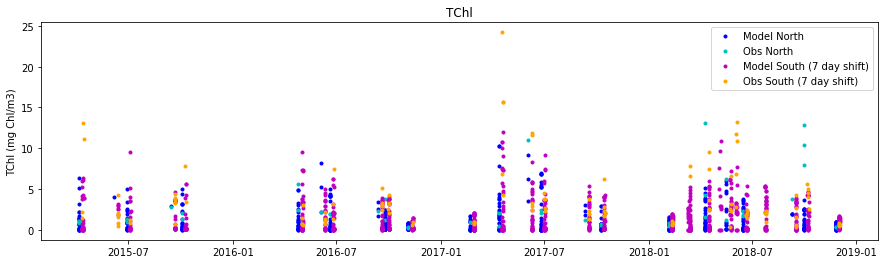

In [24]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(data2.loc[r1,['dtUTC']].values,
        1.8*(data2.loc[r1,['mod_diatoms']].values+data2.loc[r1,['mod_flagellates']].values+\
             data2.loc[r1,['mod_ciliates']].values),'b.',label='Model North')
ax.plot(data2.loc[r1,['dtUTC']].values,
        data2.loc[r1,['TchlA (ug/L)']].values,
        'c.',label='Obs North')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        1.8*(data2.loc[r2,['mod_diatoms']].values+data2.loc[r2,['mod_flagellates']].values+\
             data2.loc[r2,['mod_ciliates']].values),
        'm.',label='Model South (7 day shift)')
ax.plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],
        data2.loc[r2,['TchlA (ug/L)']].values,
        '.',color='orange',label='Obs South (7 day shift)')
ax.set_ylabel('TChl (mg Chl/m3)')
ax.set_title('TChl');
ax.legend()

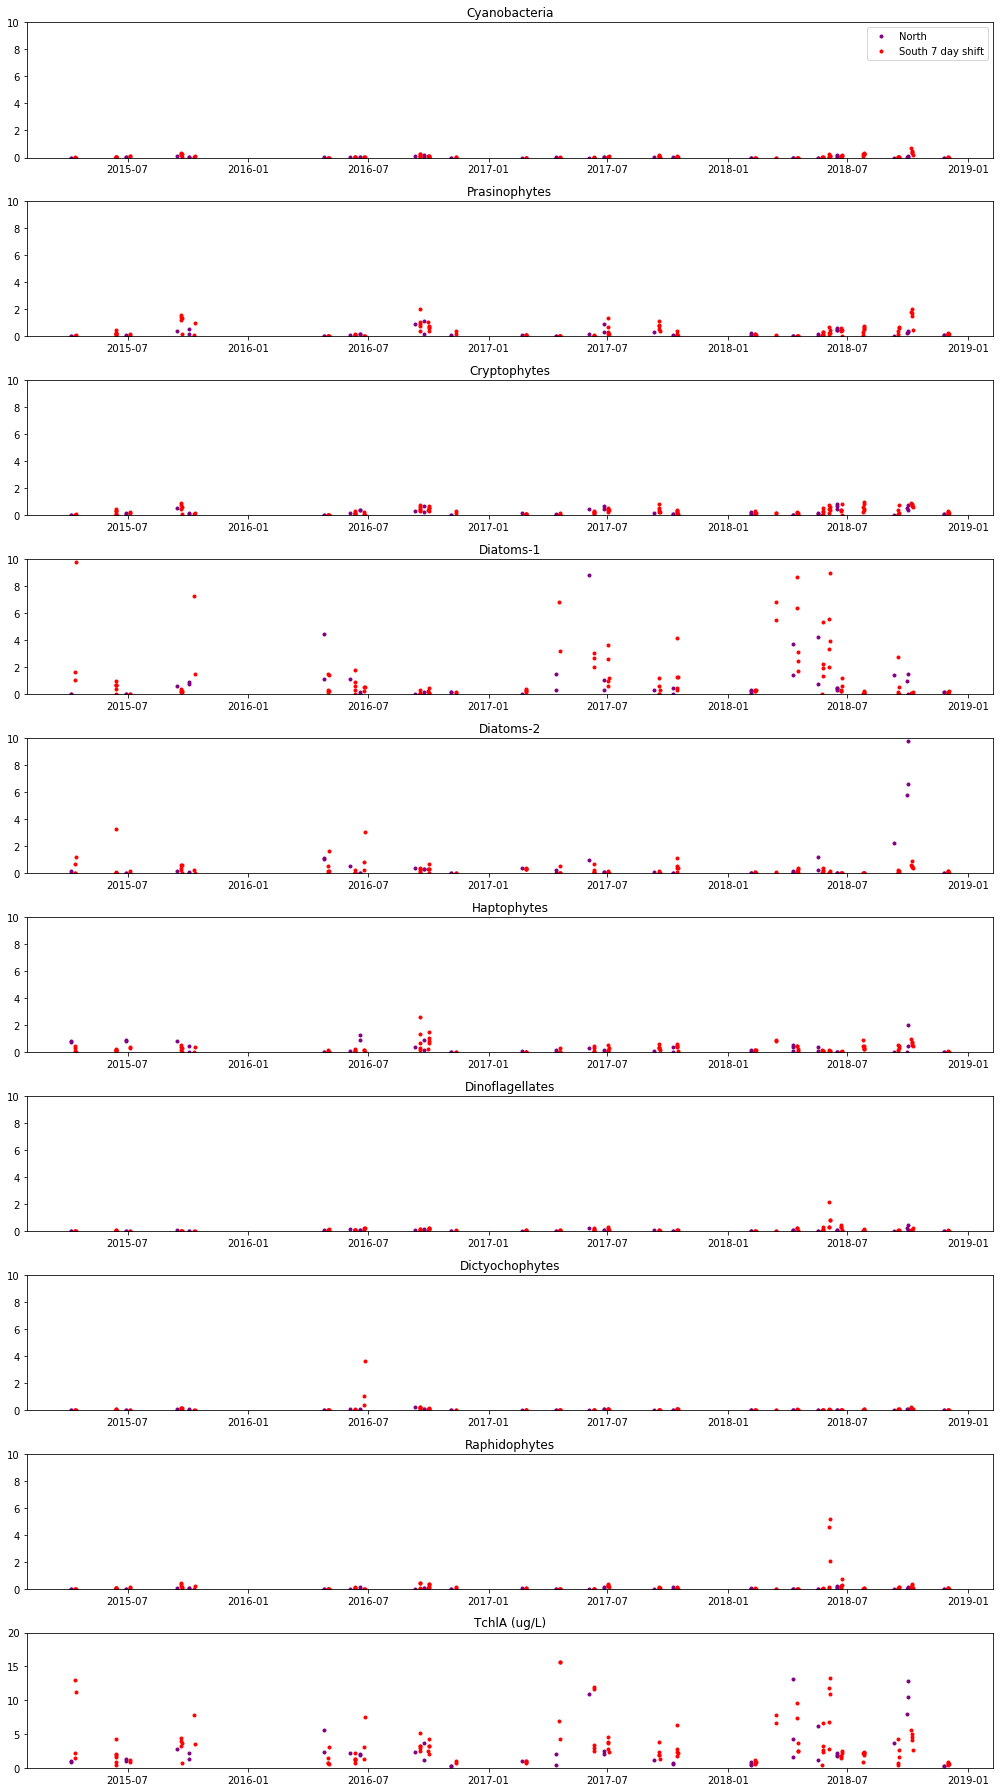

In [25]:
fig,ax=plt.subplots(10,1,figsize=(14,25))
ax=ax.flatten()

chplc=('Cyanobacteria','Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'Dinoflagellates', 'Dictyochophytes','Raphidophytes','TchlA (ug/L)')
for ii in range(0,len(chplc)):
    ax[ii].plot(data2.loc[r1,['dtUTC']],data2.loc[r1,[chplc[ii]]],'.',color='purple',label='North')
    ax[ii].plot([pd.to_datetime(ii)+dt.timedelta(days=7) for ii in data2.loc[r2,['dtUTC']].values[:,0]],data2.loc[r2,[chplc[ii]]],'.',color='red',label='South 7 day shift')
    ax[ii].set_title(chplc[ii])
    ax[ii].set_ylim(0,10)
plt.tight_layout()
ax[ii].set_ylim(0,20)
ax[0].legend()

## Correlations

In [26]:
chplc2=list(chplc)+['other']

In [27]:
r0=~pd.isnull(data2['Diatoms-1'])
cc=np.corrcoef(data2.loc[r1&r0,['mod_diatoms',]+list(chplc)+['other']],rowvar=False)
print('Correlation Coefficients, North')
print('  Model Diatoms With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))
cc=np.corrcoef(data2.loc[r1&r0,['mod_ciliates',]+list(chplc)+['other']],rowvar=False)
print('  Model Ciliates With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))
cc=np.corrcoef(data2.loc[r1&r0,['mod_flagellates',]+list(chplc)+['other']],rowvar=False)
print('  Model Flagellates With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))

Correlation Coefficients, North
  Model Diatoms With:
    Cyanobacteria :  -0.29
    Prasinophytes :  -0.34
    Cryptophytes :  -0.26
    Diatoms-1 :  0.43
    Diatoms-2 :  -0.05
    Haptophytes :  -0.01
    Dinoflagellates :  0.03
    Dictyochophytes :  -0.19
    Raphidophytes :  -0.31
    TchlA (ug/L) :  0.22
    other :  -0.23
  Model Ciliates With:
    Cyanobacteria :  -0.02
    Prasinophytes :  -0.00
    Cryptophytes :  0.03
    Diatoms-1 :  0.25
    Diatoms-2 :  0.16
    Haptophytes :  0.13
    Dinoflagellates :  0.05
    Dictyochophytes :  -0.04
    Raphidophytes :  -0.03
    TchlA (ug/L) :  0.29
    other :  0.08
  Model Flagellates With:
    Cyanobacteria :  0.32
    Prasinophytes :  0.53
    Cryptophytes :  0.58
    Diatoms-1 :  -0.06
    Diatoms-2 :  0.01
    Haptophytes :  0.22
    Dinoflagellates :  0.27
    Dictyochophytes :  0.36
    Raphidophytes :  0.37
    TchlA (ug/L) :  0.10
    other :  0.55


In [28]:
r0=~pd.isnull(data2['Diatoms-1'])
cc=np.corrcoef(data2.loc[r2&r0,['mod_diatoms',]+list(chplc)+['other']],rowvar=False)
print('Correlation Coefficients, South')
print('  Model Diatoms With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))
cc=np.corrcoef(data2.loc[r2&r0,['mod_ciliates',]+list(chplc)+['other']],rowvar=False)
print('  Model Ciliates With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))
cc=np.corrcoef(data2.loc[r2&r0,['mod_flagellates',]+list(chplc)+['other']],rowvar=False)
print('  Model Flagellates With:')
for ii in range(0,len(chplc2)):
    print('   ',chplc2[ii],': ','{:.2f}'.format(cc[0,ii+1]))

Correlation Coefficients, South
  Model Diatoms With:
    Cyanobacteria :  -0.22
    Prasinophytes :  -0.27
    Cryptophytes :  -0.33
    Diatoms-1 :  0.72
    Diatoms-2 :  -0.03
    Haptophytes :  -0.13
    Dinoflagellates :  -0.08
    Dictyochophytes :  -0.10
    Raphidophytes :  -0.11
    TchlA (ug/L) :  0.60
    other :  -0.29
  Model Ciliates With:
    Cyanobacteria :  0.11
    Prasinophytes :  -0.01
    Cryptophytes :  -0.07
    Diatoms-1 :  0.46
    Diatoms-2 :  0.07
    Haptophytes :  0.13
    Dinoflagellates :  -0.04
    Dictyochophytes :  -0.12
    Raphidophytes :  -0.05
    TchlA (ug/L) :  0.44
    other :  -0.03
  Model Flagellates With:
    Cyanobacteria :  0.37
    Prasinophytes :  0.47
    Cryptophytes :  0.47
    Diatoms-1 :  -0.20
    Diatoms-2 :  -0.01
    Haptophytes :  0.39
    Dinoflagellates :  -0.10
    Dictyochophytes :  0.00
    Raphidophytes :  -0.07
    TchlA (ug/L) :  -0.08
    other :  0.32


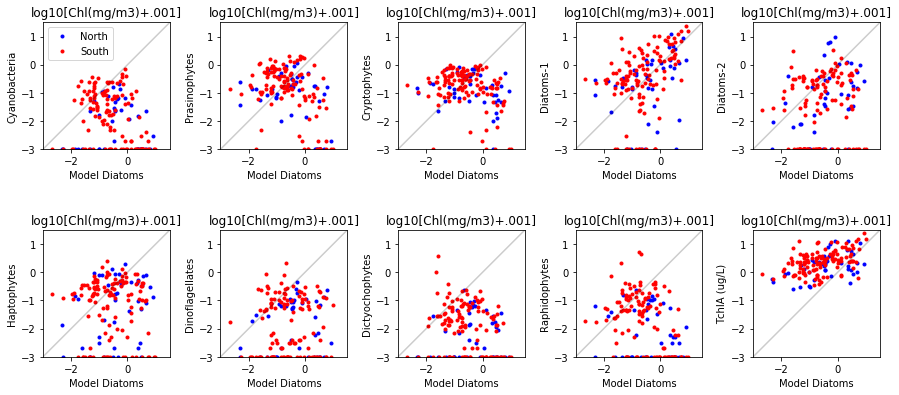

In [29]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Cyanobacteria','Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'Dinoflagellates', 'Dictyochophytes','Raphidophytes','TchlA (ug/L)')

mvar1=1.8*data2.loc[r1,['mod_diatoms']].values
mvar2=1.8*data2.loc[r2,['mod_diatoms']].values

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(mvar1),logt(data2.loc[r1,[chplc[ii]]].values),'.',color='blue',label='North')
    ax[ii].plot(logt(mvar2),logt(data2.loc[r2,[chplc[ii]]].values),'.',color='red',label='South')
    ax[ii].set_xlabel('Model Diatoms')
    ax[ii].set_ylabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


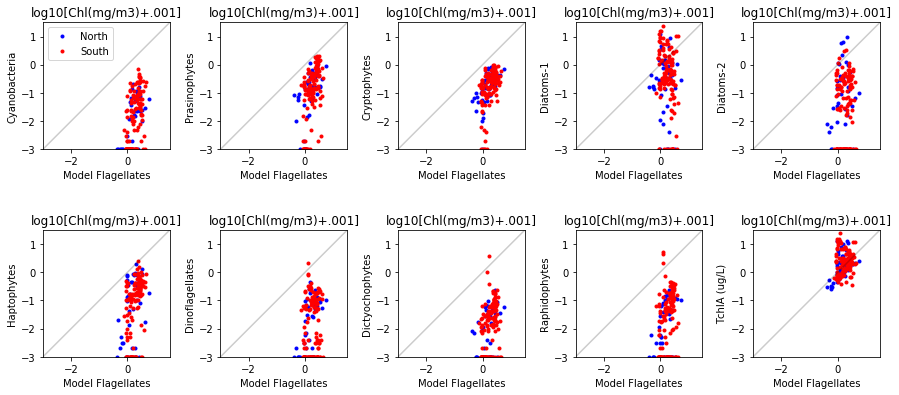

In [30]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Cyanobacteria','Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'Dinoflagellates', 'Dictyochophytes','Raphidophytes','TchlA (ug/L)')

mvar1=1.8*data2.loc[r1,['mod_flagellates']].values
mvar2=1.8*data2.loc[r2,['mod_flagellates']].values

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(mvar1),logt(data2.loc[r1,[chplc[ii]]].values),'.',color='blue',label='North')
    ax[ii].plot(logt(mvar2),logt(data2.loc[r2,[chplc[ii]]].values),'.',color='red',label='South')
    ax[ii].set_xlabel('Model Flagellates')
    ax[ii].set_ylabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


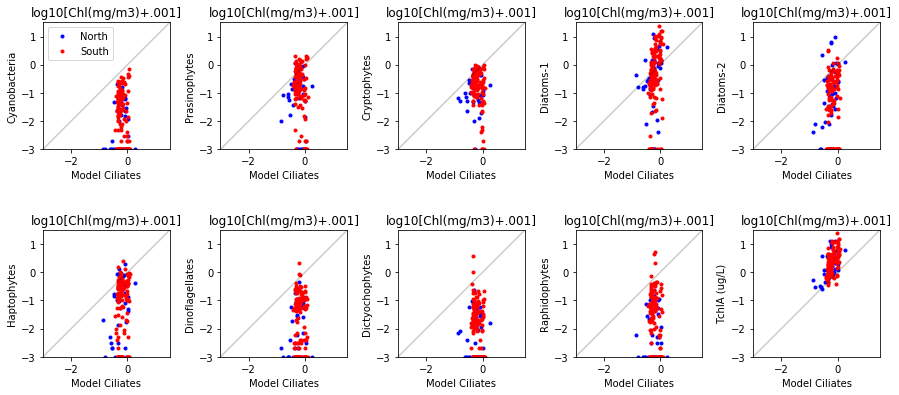

In [31]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Cyanobacteria','Prasinophytes', 'Cryptophytes', 'Diatoms-1', 'Diatoms-2',
       'Haptophytes', 'Dinoflagellates', 'Dictyochophytes','Raphidophytes','TchlA (ug/L)')

mvar1=1.8*data2.loc[r1,['mod_ciliates']].values
mvar2=1.8*data2.loc[r2,['mod_ciliates']].values

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(mvar1),logt(data2.loc[r1,[chplc[ii]]].values),'.',color='blue',label='North')
    ax[ii].plot(logt(mvar2),logt(data2.loc[r2,[chplc[ii]]].values),'.',color='red',label='South')
    ax[ii].set_xlabel('Model Ciliates')
    ax[ii].set_ylabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


## Focus on diatoms vs non-diatoms

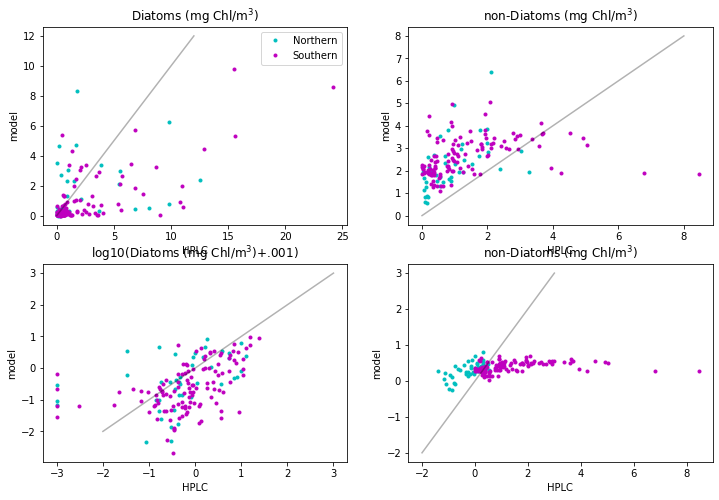

In [32]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()

iax=ax[0]; title='Diatoms (mg Chl/m$^3$)'
iax.plot(data2.loc[r1,['Diatoms-1']].values+data2.loc[r1,['Diatoms-2']].values,1.8*data2.loc[r1,['mod_diatoms']],'c.',label='Northern')
iax.plot(data2.loc[r2,['Diatoms-1']].values+data2.loc[r2,['Diatoms-2']].values,1.8*data2.loc[r2,['mod_diatoms']],'m.',label='Southern')
iax.set_title(title)
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((0,12),(0,12),'k-',alpha=.3)
iax.legend()


iax=ax[1]; title='Non-Diatoms (mg Chl/m$^3$)'
iax.plot(data2.loc[r1,['other']].values,1.8*(data2.loc[r1,['mod_flagellates']].values+data2.loc[r1,['mod_ciliates']].values),'c.')
iax.plot(data2.loc[r2,['other']].values,1.8*(data2.loc[r2,['mod_flagellates']].values+data2.loc[r2,['mod_ciliates']].values),'m.')
iax.set_title('non-Diatoms (mg Chl/m$^3$)')
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((0,8),(0,8),'k-',alpha=.3)


iax=ax[2]; title='log10(Diatoms (mg Chl/m$^3$)+.001)'
iax.plot(logt(data2.loc[r1,['Diatoms-1']].values+data2.loc[r1,['Diatoms-2']].values),logt(1.8*data2.loc[r1,['mod_diatoms']]),'c.',label='Northern')
iax.plot(logt(data2.loc[r2,['Diatoms-1']].values+data2.loc[r2,['Diatoms-2']].values),logt(1.8*data2.loc[r2,['mod_diatoms']]),'m.',label='Southern')
iax.set_title(title)
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((-2,3),(-2,3),'k-',alpha=.3)

iax=ax[3]; title='log10(Non-Diatoms (mg Chl/m$^3$)+.001)'
iax.plot(logt(data2.loc[r1,['other']].values),logt(1.8*(data2.loc[r1,['mod_flagellates']].values+data2.loc[r1,['mod_ciliates']].values)),'c.')
iax.plot(data2.loc[r2,['other']].values,logt(1.8*(data2.loc[r2,['mod_flagellates']].values+data2.loc[r2,['mod_ciliates']].values)),'m.')
iax.set_title('non-Diatoms (mg Chl/m$^3$)')
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((-2,3),(-2,3),'k-',alpha=.3)

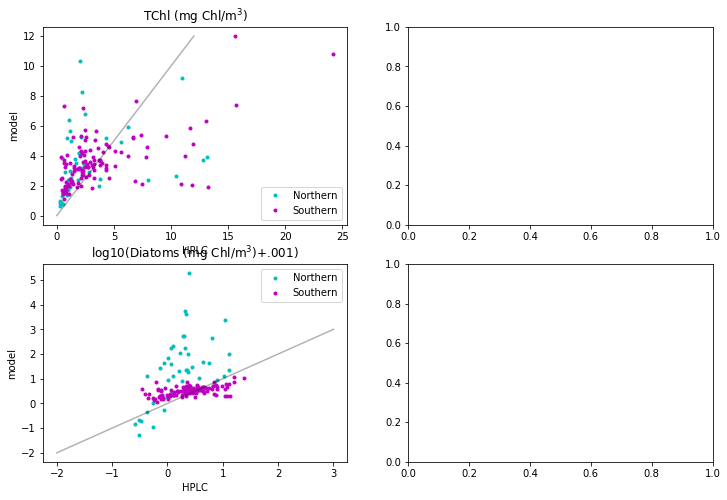

In [33]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()

iax=ax[0]; title='TChl (mg Chl/m$^3$)'
iax.plot(data2.loc[r1,['TchlA (ug/L)']].values,
        1.8*(data2.loc[r1,['mod_flagellates']].values+\
             data2.loc[r1,['mod_ciliates']].values+\
             data2.loc[r1,['mod_diatoms']].values),'c.',label='Northern')
iax.plot(data2.loc[r2,['TchlA (ug/L)']].values,
        1.8*(data2.loc[r2,['mod_flagellates']].values+\
             data2.loc[r2,['mod_ciliates']].values+\
             data2.loc[r2,['mod_diatoms']].values),'m.',label='Southern')
iax.set_title(title)
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((0,12),(0,12),'k-',alpha=.3)
iax.legend()


iax=ax[2]; title='log10(Diatoms (mg Chl/m$^3$)+.001)'
iax.plot(logt(data2.loc[r1,['TchlA (ug/L)']].values),
        1.8*(data2.loc[r1,['mod_flagellates']].values+\
             logt(data2.loc[r1,['mod_ciliates']].values+\
             data2.loc[r1,['mod_diatoms']].values)),'c.',label='Northern')
iax.plot(logt(data2.loc[r2,['TchlA (ug/L)']].values),
        logt(1.8*(data2.loc[r2,['mod_flagellates']].values+\
             data2.loc[r2,['mod_ciliates']].values+\
             data2.loc[r2,['mod_diatoms']].values)),'m.',label='Southern')
iax.set_title(title)
iax.set_xlabel('HPLC')
iax.set_ylabel('model')
iax.plot((-2,3),(-2,3),'k-',alpha=.3)
iax.legend()

